<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Danial Parnian</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 401110307</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [1]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

plt.rcParams['figure.dpi'] = 100

In [2]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [3]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** Agents that rely on uniform exploration (like Explore-First and Epsilon-Greedy) may perform worse, because they would spend a lot of time exploring suboptimal arms.


In [4]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** Probably for simplicity. No extra complexity is added to problem (like continuous distributions for rewards), and we can easily focus on exploration-exploitation tradeoff.

In [5]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [6]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [7]:
# Compute oracleReward using privileged info (simple placeholder)
oracleReward = max(p_arr)
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** It indicates the reward after choosing the best arm, and therefore is an upper bound on performance.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** Because in real world problems, we don't know the expected reward of arms, and the whole point of MAB is to estimate those and find optimal arm. So we shouldn't rely on oracle.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [8]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # get a random action index [Simple]
        sel_act = np.random.choice(self.n_act)
        return sel_act

In [9]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

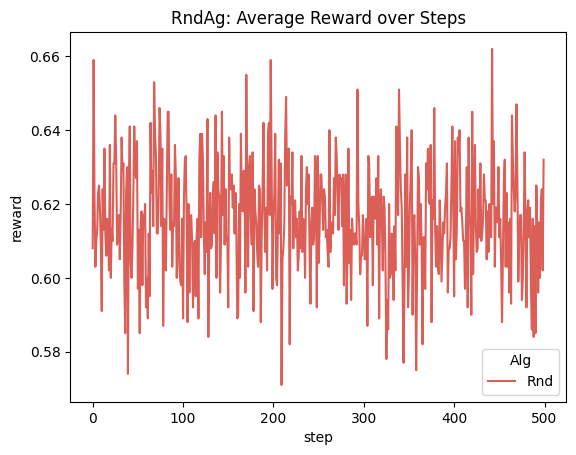

In [10]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** Because there is no learning, and agent just selects arms randomly all the time, so it'll pick suboptimal actions.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** we can implement a weighted random selection, if we have any information about the environment and rewards. For example if we know some arms are better, assign them higher probability.

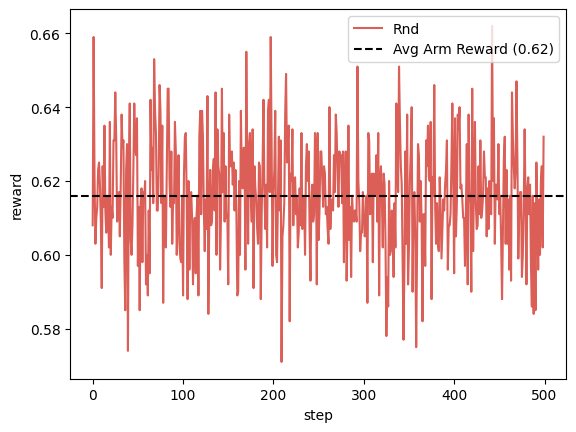

In [11]:
# Plot RndAg reward curve and average reward of all arms (Simple)
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
avg_arm_reward = rnd_log['reward'].mean()
plt.axhline(y=avg_arm_reward, color='black', linestyle='--', label=f'Avg Arm Reward ({avg_arm_reward:.2f})')
plt.legend()
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [12]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # update Q value
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act] # Average reward

    def get_action(self):
        self.t += 1
        # Choose random action for t <= max_ex, else best arm [Simple]
        if self.t <= self.max_ex:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = np.argmax(self.Q)
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

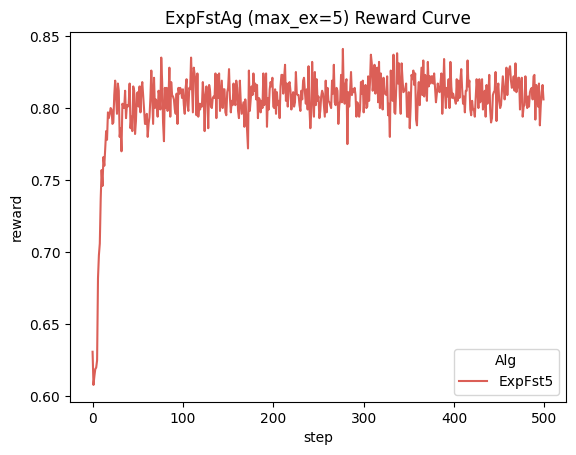

In [13]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** Because the agent is selecting arms randomly, to gather information and have better estimates, and is still not using its information. Therefore, it selects all arms (almost) equivalently which leads to fluctuations in the reward curve.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** It is simple to implement and helps us have prior knowledge on all arms, but on the other hand, the exploration may not be enough to have good estimates, especially if reward distributions are noisy. Also, it can be inefficient, if some arms have terrible rewards and easily estimated, but we would still pick them a constant number in the exploration phase and intentionally delay the exploitation. So we have to carefully tune exploration values and even with that, still might face the mentioned challenges.

Alg Sweeps:   0%|          | 0/5 [00:00<?, ?it/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]

Runs:   0%|          | 0/2000 [00:00<?, ?it/s]

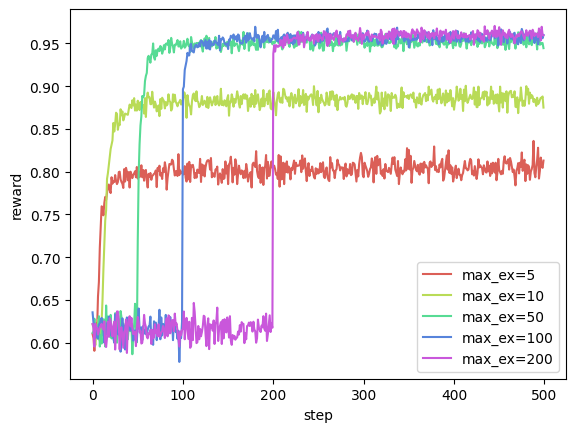

In [14]:
# Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] (Simple placeholder)
max_ex_values = [5, 10, 50, 100, 200]
agents = [ExpFstAg(n_act=nArms, max_ex=ex) for ex in max_ex_values]
labels = [f'max_ex={ex}' for ex in max_ex_values]

# Run the MAB experiment
logs = mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500)

# Plot the results
plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

plt.legend()
plt.show()
    

**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** It delays the initial convergence, and forces agent to spend more time exploring (which could be either helpful and harmful).

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** The optimal exploration duration depends on the reward distribution, which is often unknown. Also, if the reward distributions change over time, we can't use a fixed exploration duration. In general, determining when the exploration phase is enough, and we should enter exploitation, is difficult and setting the value too high or too low is dangerous.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [15]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Update Q value
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # Compute exploration bonus
        bonus = np.sqrt(2 * np.log(self.t) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

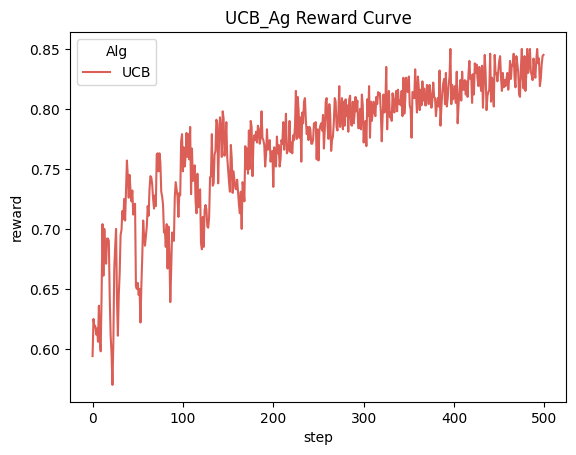

In [16]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** In scenarios when the exploration phase of Explore-First algorithm quickly finds the optimal arm (for example when environment is too simple and reward distributions are simple, like here which is Bernoulli), it would converge faster than UCB.

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** Explore-First is better in short term, since it quickly estimates value of different arms. But it may perform worse in long term if the exploration phase is insufficient. UCB balances short and long term performances by being conservative, but still exploring high potential arms. But comparing to Explore-First, it starts slower and overtakes over time.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.

**A:** Because it balances exploration and exploitation and tries to explore only high-potential arms or less-picked ones, and it may take long to be able to find optimal arm. But this conservative attitude could be good, especially because it avoids randomly picking terrible arms just for the sake of exploration, and performs a smarter exploration.


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

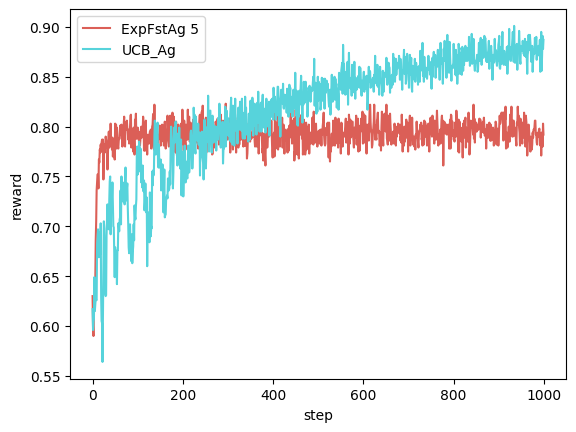

In [17]:
# Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
# Initialize agents
expfst_agent = ExpFstAg(n_act=nArms, max_ex=5)
ucb_agent = UCB_Ag(n_act=nArms)

# Labels for the agents
labels = ['ExpFstAg 5', 'UCB_Ag']

# Run the MAB experiment
agents = [expfst_agent, ucb_agent]
logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=1000)

# Plot the results
plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

plt.legend()
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** Answered above.

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** Answered above.

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

**A:** It finds more accurate estimates for q-values and therefore quickly finds optimal arm. As you can see in the plot, it outperforms UCB rapidly.

Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

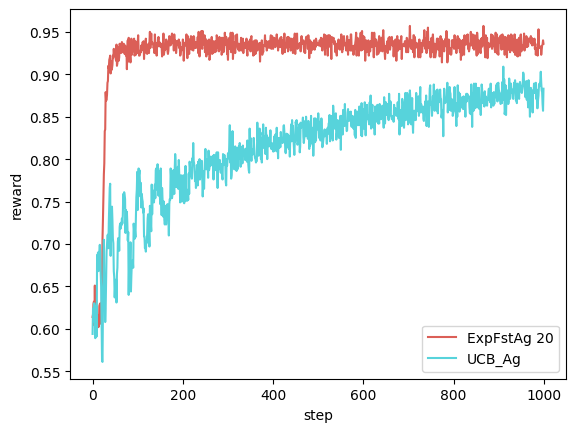

In [18]:
# Run comparison for ExpFstAg (max_ex=20) and UCB_Ag (Simple placeholder)
# Initialize agents
expfst_agent = ExpFstAg(n_act=nArms, max_ex=20)
ucb_agent = UCB_Ag(n_act=nArms)

# Labels for the agents
labels = ['ExpFstAg 20', 'UCB_Ag']

# Run the MAB experiment
agents = [expfst_agent, ucb_agent]
logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=1000)

# Plot the results
plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

plt.legend()
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** It increases the exploration phase duration, which leads to a more accurate estimate of arm rewards, and rapidly find the optimal arm. As you can see in the plot, it even outperforms UCB in only 20 steps.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** It requires monitoring performance indicators like reward variance, stabilization of Q-values, or drops in reward, and using these signals to adjust the exploration strategy.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** Due to early exploitation. A well tuned exploration phase in ExpFstAg can quickly identify a near-optimal arm, which allows faster exploitation compared to UCBs more cautious exploration, and outperform it in finite-time scenarios.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

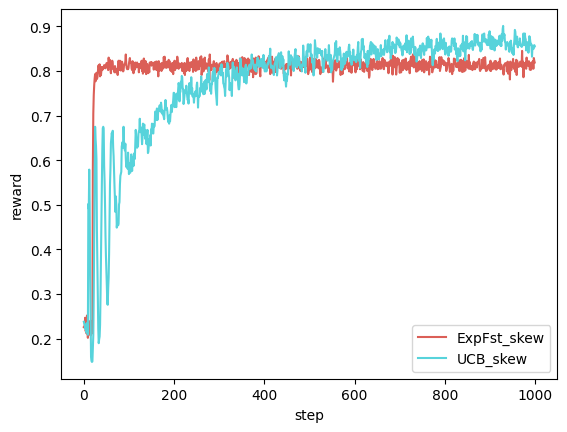

In [19]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario
# Initialize agents
expfst_agent = ExpFstAg(n_act=nArms, max_ex=len(skewed_p))
ucb_agent = UCB_Ag(n_act=nArms)

# Labels for the agents
labels = [f'ExpFst_skew', 'UCB_skew']

# Run the MAB experiment
agents = [expfst_agent, ucb_agent]
logs = mab_swp(agents, skewed_p, labels, n_runs=1000, max_steps=1000)

# Plot the results
plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

plt.legend()
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [20]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # Choose random action with probability eps
        if np.random.random() < self.eps:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = np.argmax(self.Q)
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** Because the agent explores more often, selecting suboptimal actions with higher probability instead of exploiting the current best estimate, which leads to lower rewards.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** Decaying ε over time allows for initial exploration to find accurate reward estimates, and then increase exploitation as the agent becomes more confident about its estimates. This balances exploration and exploitation effectively.


Alg Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

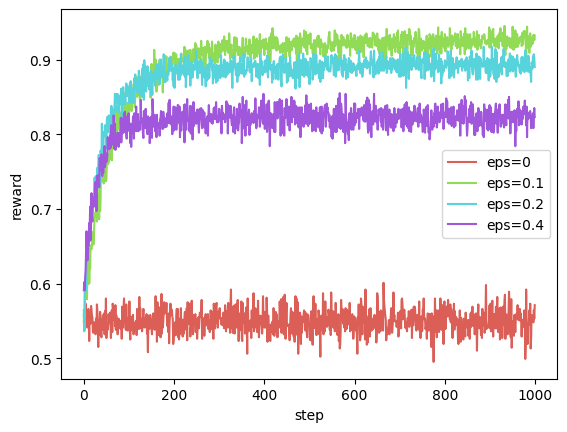

In [21]:
# Plot reward curves for EpsGdAg with epsilons [0, 0.1, 0.2, 0.4]
# Initialize agents with different epsilon values
epsilon_values = [0, 0.1, 0.2, 0.4]
agents = [EpsGdAg(n_act=nArms, eps=eps) for eps in epsilon_values]
labels = [f'eps={eps}' for eps in epsilon_values]

# Run the MAB experiment
logs = mab_swp(agents, p_arr, labels, n_runs=1000, max_steps=1000)

# Plot the results
plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

plt.legend()
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** ε=0 is the worst because we don't explore at all. ε=0.1 balances exploration and exploitation effectively and achieves the best result, amd increasing ε more than that leads to damage to performance over time (less exploitation).

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** When the environment is non-stationary or when there is high uncertainty about the true reward distributions. In such cases we prefer more and continuous exploration, encouraging us to pick higher epsilon.


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [22]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [23]:
# Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
ctxData = np.loadtxt('dataset.txt')
print("Dataset loaded:", ctxData)

Dataset loaded: [[ 2.  0.  5. ... 30.  4.  0.]
 [ 8.  0.  1. ...  0.  0. 10.]
 [ 5.  0.  3. ...  3.  0.  0.]
 ...
 [ 9.  1. 79. ...  0.  0.  0.]
 [ 4.  0. 29. ... 17.  0.  0.]
 [ 4.  0.  0. ...  0.  0. 12.]]


In [24]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act+1 == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [25]:
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        state = state.reshape(-1, 1)
        # Compute UCB for arm a given state
        A_inv = np.linalg.inv(self.As[a])
        theta = A_inv @ self.bs[a]
        p = (theta.T @ state + self.alpha * np.sqrt(state.T @ A_inv @ state)).item()
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        state = state.reshape(-1, 1)
        # Update A and b for arm a
        self.As[a] += state @ state.T
        self.bs[a] += rew * state

    def get_action(self, state):
        # Compute UCB estimates for all arms
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        sel_act = np.argmax(p_est)
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** it incorporates state features into the rewards estimates, and considers the context, unlike classical algorithms that treat each arm independently.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** It controls the exploration term. A higher α leads to more exploration by increasing effect of UCBs. A lower α leads to more exploitation by reducing that term.

In [26]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [27]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [28]:
# Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1
alphas = [0, 0.01, 0.1, 0.5]
n_runs = 1
logs_ctx = ctxBnd_swp(alphas=alphas, data=ctxData, n_runs=n_runs)

Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

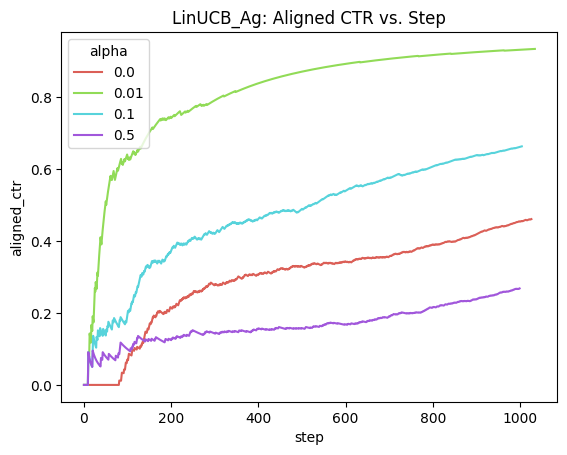

In [29]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', errorbar=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** Higher alpha encourages more exploration and therefore finding more accurate estimates. But increasing it more than a certain amount, might delay exploitation and lead to worse short-term performance.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** **α**=0.01 is the best value and balances between exploration and exploitation well. higher values delay the exploitation and decrease rewards in short term, and **α**=0 has little exploration which leads to weak performance. So the reward curves change, as you can see.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** It's difficult to pick one of them! it totally depends on the problem. LinUCB uses contextual information, and if we have relevant contexts, and also the linear combination of them could determine reward, LinUCB could use these data and perform better. When context isn't informative, we could use simple UCB.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** LinUCB relies on a linear relationship between context and reward, which may not hold. It can also suffer from overfitting in high-dimensional contexts. UCB Ignores context, which can lead to suboptimal decisions when context is informative.
when context is highly informative and a linear relationship is plausible, it's better to use LinUCB. otherwise, UCB is the best option.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

**A:** In a finite-horizon scenario an optimal algorithm like UCB may perform poorly because its exploration bonus, tuned for the long term, can delay exploitation, leading to high early regret despite eventual convergence. Aggressive early exploration may quickly identify the best arm and cautious long-term learning balances exploration and exploitation over a longer time.

## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.

**A:** If hyperparameters are too small, we may underexplore and dont find accurate estimates, and therefore choosing and unoptimal arm. In the other hand, setting them too high leads to overexplore and despite finding accurate enough estimates, we may force the model to explore more and not exploit, which leads to higher unnecessary regret. A self-adaptive mechanism could monitor performance indicators like reward variance to dynamically adjust exploration. For example, high reward variance indicates the need for more exploration, while stable rewards indicate it's time to exploit.

## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

**A:** When the true relationship between context and reward is complex and non-linear, LinUCB may fail to estimate q-values, which leads to bad performance. In high-dimensional and noisy contexts, the linear assumption can lead to overfitting, where the model fits the noise rather than the underlying relationship. Adding context may lead to worse performance than classical UCB when the context is irrelevant or noisy or when the linear assumption is a poor fit for the true relationship.
One solution is to use dimensionality reduction techniques (like PCA) to reduce number of features and noise. We can also use regularization to prevent overfitting.

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.

**A:** A hybrid bandit agent can switch between explore-first and UCB based on performance signals. High variance in reward estimates, unstable Q-values, or sudden reward drops suggest more exploration is needed. Stabilization of Q-values or consistently high rewards indicates it's time to exploit. This strategy can outperform both algoritms by adapting to different phases of the learning process and take the good part of both algorithms (explore first to quickly find good estimates, and then UCB to balance exploitation and exploration for the rest).


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

**A:** A forgetting mechanism improves performance by down-weighting past rewards, which allows the algorithm to adapt to changing reward probabilities. Choosing the right decay rate is crucial: a high decay rate may lead to chasing noise, while a low rate might delay adaptation. The decay rate determines how quickly the algorithm trusts recent rewards over older ones, and balances between exploration and exploitation balance.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.

**A:** A conservative (high) bonus in UCB can slow down learning by forcing continued sampling of suboptimal arms, delaying convergence, even with asymptotic optimality guarantees. A less conservative bonus can be beneficial when quick convergence is prioritized, but it has the risk of prematurely discarding potentially good arms due to under exploration.

## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.

**A:** A short exploration can lead to high regret if the initial samples guide the agent towards false reward distributions (happens when distributions are more complex and wide). A longer exploration phase might delay exploitation unnecessarily if the optimal arm is quickly identified (like in a simple environment).
The optimal exploration duration depends on the reward distribution's variance and the gap between the best and other arms. As explained above, if the optimal arm is easily found, we shouldn't explore too much and delay the exploitation, also in high variance scenarios we need more exploration. Therefor a one-size-fits-all approach isn't good and we may act based on the problem.

## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.

**A:** Bayesian methods (like Thompson Sampling) use prior beliefs to guide exploration, while frequentist methods (like UCB) rely on observed data. Bayesian approaches can be better when you have good prior knowledge. The accuracy of prior knowledge affects how well Bayesian methods balance exploration and exploitation.

## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.

**A:** UCB (or ExpFstAg) struggle because high variance in rewards can mislead the agent, causing it to explore suboptimal arms longer. UCB tends to explore less-picked arms more to make estimates more accurate, and Explore-First just randomly picks them more than needed (because we can quickly notice these arms aren't useful due to small q-values). Skewed probabilities and rare high rewards can distort reward estimation, delaying the identification of the best arm.

## Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

**A:** In contextual bandits with many features but only a few being useful, LinUCB faces challenges because it tries to learn weights for all features, which can lead to overfitting and poor performance (This is also a challenge in classic classification ML problems with high dimensional feature vectors). To address the problem, feature selection helps by focusing on the most relevant features, regularization prevents overfitting by penalizing large weights, and Non-linear models can capture complex relationships (but are computationally expensive). For example we can use a neural network, which increases the complexity of problem. The trade-offs involve balancing model complexity, computational cost, and the risk of overfitting versus underfitting.
